In [691]:
import numpy as np
import glob
from scipy import integrate, interpolate
import matplotlib
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['ytick.minor.visible'] = True
matplotlib.rcParams['lines.dash_capstyle'] = "round"
matplotlib.rcParams['lines.solid_capstyle'] = "round"
matplotlib.rcParams['legend.handletextpad'] = 0.4

import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{cmbright}  \usepackage[T1]{fontenc}')

matplotlib.rcParams['axes.linewidth'] = 0.6
matplotlib.rcParams['ytick.major.width'] = 0.6
matplotlib.rcParams['xtick.major.width'] = 0.6
matplotlib.rcParams['ytick.minor.width'] = 0.45
matplotlib.rcParams['xtick.minor.width'] = 0.45
matplotlib.rcParams['ytick.major.size'] = 2.75
matplotlib.rcParams['xtick.major.size'] = 2.75
matplotlib.rcParams['ytick.minor.size'] = 1.75
matplotlib.rcParams['xtick.minor.size'] = 1.75
matplotlib.rcParams['legend.handlelength'] = 1.5

import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.colors import ListedColormap
import palettable
from scipy.integrate import ode
from scipy.integrate import solve_ivp
from scipy import optimize
import cmasher as cmr
import matplotlib.font_manager
from numpy import random


from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from ipynb.fs.full.utils import Matrix3D
import time

###########################
gamma   = 5/3.
kb      = 1.3806488e-16
mp      = 1.67373522381e-24
km      = 1e5
s       = 1
yr      = 3.1536e7
Myr     = 3.1536e13
Gyr     = 3.1536e16
pc      = 3.086e18
kpc     = 1.0e3 * pc
Mpc     = 1.0e6 * pc
H0      = 67.74*km/s/Mpc
Om      = 0.3075
OL      = 1 - Om
G       = 6.673e-8
Msun    = 2.e33
fb      = 0.158
keV     = 1.60218e-9
###########################


###########################
mu          = 0.62
metallicity = 10**-0.5
muH         = 1/0.75
###########################



Z0 = 1/3.
P0 = 1e3
T0 = 1e6
n0 = P0/T0
redshift=0
chi0 = 100.
Mach0 = 0.0
Turbulent_Scale0 = 1*kpc
f_turb0 = 0.1
f_mix = 0.1
v_hot0 = 0.
f_cool = 0.3
f_ad = 0.1

P = 1e4*kb
rho = 1e-2*mu*mp


In [692]:
def dot_cloud(M_cloud,v_cloud, tcool):
    # cloud_radius(M_cloud,v_cloud):
    T_cloud   = 1e4
    rho_cloud   = P * (mu*mp) / (kb*T_cloud) # cloud in pressure equilibrium
    chi         = rho_cloud / rho
    r_cloud     = (M_cloud / (rho_cloud))**(1/3.) 
    # layer_turbulent_velocity(M_cloud,v_cloud):
    v_turb      = f_turb0*(v-v_cloud)
    # layer_cooling_time(M_cloud,v_cloud):
    t_cool_layer = tcool ## just use this for now
    # cloud_ksi(M_cloud,v_cloud):
    T_wind  = P/kb * (mu*mp/rho)
    T_mix   = np.sqrt(T_wind*T_cloud)
    ksi     = r_cloud / (v_turb * t_cool_layer)
    # Mdot_cloud_grow(M_cloud,v_cloud):
    Mdot_grow   =  M_cloud * v_turb / (r_cloud * chi**Mdot_chi_power) * np.where( ksi < 1, ksi**0.5, ksi**0.25 )
    Mdot_loss   = -M_cloud * v_turb / (r_cloud * chi**Mdot_chi_power) 
    force_from_transfer = (v-v_cloud)*Mdot_grow
    return force_from_transfer/M_cloud, Mdot_grow + Mdot_loss

In [693]:
def gen_bins(bmin, bmax, logScale, nbs_bins, unit):
    bin_size = (bmax-bmin)/nbs_bins
    bins = np.arange(bmin,bmax,bin_size)
    if logScale==True: 
        bins = 10**bins * unit
    else:
        bins = bins * unit
    return bins


def gen_lognormal_dist(nbsample, logmean, logstd, unit):
    sample=random.normal(logmean, logstd, nbsample)
    return 10 ** sample * unit

def gen_normal_dist(nbsample, mean, std, unit):
    sample=random.normal(mean, std, nbsample)
    return sample * unit

def gen_powerlaw(nbsample, xmin, xmax, power, unit):
    r = np.random.random(size=nbsample)
    ag, bg = xmin**power, xmax**power
    return (ag + (bg - ag)*r) ** (1./power) * unit

def gen_cloud(v_samples, m_samples):
    sample=[]
    nb_vsam = len(v_samples)
    nb_msam = len(m_samples)
    if nb_vsam != nb_msam:
        print("number of samples of velocity and Mass does not match")
    for i in range(nb_vsam):
        sample.append((i, v_samples[i], m_samples[i]))
    return sample

def binnings(clouds, v_bins, M_bins):
    nbs_vbin= len(v_bins)
    nbs_Mbin= len(M_bins)
    f=np.reshape(np.zeros(nbs_vbin * nbs_Mbin),(nbs_vbin,nbs_Mbin))
    v_min = v_bins[0]
    v_max = v_bins[nbs_vbin-1]
    M_min = M_bins[0]
    M_max = M_bins[nbs_Mbin-1]
    for item in clouds:
        if (item[1]>=v_min) and (item[1]<=v_max) and (item[2]>=M_min) and (item[2]<=M_max):
            v_idx = np.max(np.where(v_bins <= item[1]))
            M_idx = np.max(np.where(M_bins <= item[2]))
            f[v_idx][M_idx]+=1
    return f

def plot_density(f, downscale):
    plt.figure(figsize=(8,8))
    plt.pcolormesh((M_cloud_bins/Msun),v_cloud_bins/1e5, np.abs(f)/downscale,cmap=palettable.scientific.sequential.Oslo_20_r.mpl_colormap, norm=colors.SymLogNorm(vmin=1e-5,vmax=1e-3,linthresh=1e-6))
    plt.xscale('log')
    plt.title("Density of cloud mass vs cloud velocity")
    

def plot_vel(dens0, dens, v_cloud_bins):
    plt.figure(figsize=(6,6))
    (cells,_) = dens.shape
    bins = []
    bins0=[]
    [bins.append(sum(dens[i][:])) for i in range(cells)]
    [bins0.append(sum(dens0[i][:])) for i in range(cells)]
    plt.plot(v_cloud_bins/1e5, bins/np.sum(dens), label='final density')
    plt.plot(v_cloud_bins/1e5, bins0/np.sum(dens0), label='initial density')
    plt.title("cloud velocity density function")
    plt.legend()
    return
  

def plot_mass(dens0, dens, M_cloud_bins, logscale):
    plt.figure(figsize=(6,6))
    (_,cells) = dens.shape
    bins =[]
    bins0=[]
    [bins.append(sum(np.transpose(dens)[i][:])) for i in range(cells)]
    [bins0.append(sum(np.transpose(dens0)[i][:])) for i in range(cells)]
    if logscale:
        bins = np.log10(bins/np.sum(dens))
        bins0 = np.log10(bins0/np.sum(dens0))
    else:
        bins = bins/np.sum(dens) 
        bins0 = bins0/np.sum(dens0) 
    plt.plot(np.log10(M_cloud_bins/Msun), bins, label='final density')
    plt.plot(np.log10(M_cloud_bins/Msun), bins0, label='initial density')
    plt.title("cloud mass density function")
    plt.legend()
    return

In [694]:
def evolve_single(t,z):
    M_cloud = z[0]
    v_cloud = z[1]
    dot = dot_cloud(z[0],z[1], t_cool_layer)
    return [dot[1], dot[0]]

(-10000000.0, 200000000)

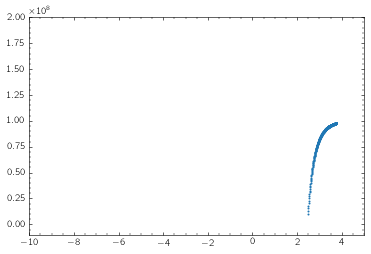

In [695]:
f_turb0 = 0.1
Mdot_chi_power = 0.5
t_cool_layer = 0.3*Myr ## 10 for ksi ~ 0.01,  0.01 for ksi~10, 0.001 for ksi~100
dt = 10**(4)*yr
timeStep = 1000
v = 1000 * km
M0 = 300 * Msun
v0 = 100 * km

r_cloud     = (M0 / (rho*100))**(1/3.)
v_turb = f_turb0*(v-v0)
t_cool_layer = r_cloud / v_turb / 10**2

Mn=[]
vn=[]
Mn.append(M0)
vn.append(v0)


M_cloud = M0
v_cloud = v0

t_cc = 10 * (M0 / (rho * 100))**(1/3) / v 

for i in range(timeStep):
    # cloud_radius(M_cloud,v_cloud):
    T_cloud   = 1e4
    rho_cloud   = P * (mu*mp) / (kb*T_cloud) # cloud in pressure equilibrium
    chi         = rho_cloud / rho
    r_cloud     = (M_cloud / (rho_cloud))**(1/3.) 
    # layer_turbulent_velocity(M_cloud,v_cloud):
    v_turb      = f_turb0*(v-v_cloud)
 
    # layer_cooling_time(M_cloud,v_cloud):
#    t_cool_layer = 1*Myr ## just use this for now
    # cloud_ksi(M_cloud,v_cloud):
    T_wind  = P/kb * (mu*mp/rho)
    T_mix   = np.sqrt(T_wind*T_cloud)
    ksi     = r_cloud / (v_turb * t_cool_layer)
    # Mdot_cloud_grow(M_cloud,v_cloud):
    Mdot_grow   =  3 * M_cloud * v_turb / (r_cloud * chi**Mdot_chi_power) * np.where( ksi < 1, ksi**0.5, ksi**0.25 )
    Mdot_loss   = -3 * M_cloud * v_turb / (r_cloud * chi**Mdot_chi_power) 
    force_from_transfer = (v-v_cloud)*Mdot_grow
    v_cloud += force_from_transfer/M_cloud * dt
    M_cloud += (Mdot_grow + Mdot_loss) * dt
    Mn.append(M_cloud)
    vn.append(v_cloud)

sol = solve_ivp(evolve_single, [0, dt*(timeStep+1)], [M0,v0], dense_output=True, first_step=dt/1e10, rtol=1e-6)    
tn=np.arange(0,timeStep*(dt+1), dt)    
plt.scatter(np.log10(np.array(Mn)/Msun),vn, s=1)
plt.xlim((-10,5))
plt.ylim((-1e7,200000000))

(0.01, 20)

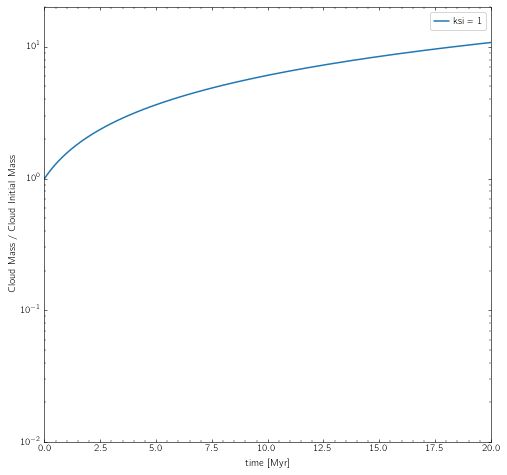

In [696]:
# R0 t_cool = 50, v=600, steps=10000, chi power = 0.1
# R1 t_cool = 100, v=600, steps=10000, chi power = 0.1
# R2 t_cool = 1000, v=600, steps=10000, chi power = 0.1
# R3 t_cool = 75, v=600, steps=10000, chi power = 0.1
plt.figure(figsize=(8,8))
plt.yscale("log")
initM = np.array([M0]*len(tn))
plt.plot(tn/t_cc,np.array(Mn)/M0, label = "ksi = 1")
#plt.plot(tn/t_cc,np.array(R3)/initM,label = "cooling time = 75")
#plt.plot(tn/t_cc,np.array(R1)/initM, label = "cooling time = 100")
#plt.plot(tn/t_cc,np.array(R2)/initM,label = "cooling time = 1000")
#plt.plot(tn/t_cc,np.array(initM/initM), color="black", linestyle="dotted")
plt.legend()
plt.xlabel('time [Myr]')
plt.ylabel('Cloud Mass / Cloud Initial Mass')
plt.xlim((0,20))
plt.ylim((0.01,20))

In [697]:
t_cool_layer = 0.2935 * Myr
r_cloud     = (M0 / (rho*100))**(1/3.)
v_turb = f_turb0*(v-v0)
r_cloud / (v_turb * t_cool_layer)

1.0000776300975203

In [701]:
M_20 = Mn
# R0 t_cool = 50, v=600, steps=10000, chi power = 0.1
# R1 t_cool = 100, v=600, steps=10000, chi power = 0.1
# R2 t_cool = 1000, v=600, steps=10000, chi power = 0.1
# R3 t_cool = 75, v=600, steps=10000, chi power = 0.1
plt.figure(figsize=(8,8))
plt.yscale("log")
initM = np.array([M0]*len(tn))
plt.plot(tn/t_cc,np.array(M20_)/M0, label = "ksi = 10$^{-2}$")
plt.plot(tn/t_cc,np.array(M15_)/M0, label = "ksi = 10$^{-1.5}$")
plt.plot(tn/t_cc,np.array(M10_)/M0, label = "ksi = 10$^{-1.0}$")
plt.plot(tn/t_cc,np.array(M05_)/M0, label = "ksi = 10$^{-0.5}$")
plt.plot(tn/t_cc,np.array(M_0)/M0, label = "ksi = 10$^{0}$")
plt.plot(tn/t_cc,np.array(M_05)/M0, label = "ksi = 10$^{0.5}$")
plt.plot(tn/t_cc,np.array(M_10)/M0, label = "ksi = 10$^{1.0}$")
plt.plot(tn/t_cc,np.array(M_15)/M0, label = "ksi = 10$^{1.5}$")
plt.plot(tn/t_cc,np.array(M_20)/M0, label = "ksi = 10$^{2.0}$")

#plt.plot(tn/t_cc,np.array(initM/initM), color="black", linestyle="dotted")
plt.legend()
plt.xlabel('t/t$_{cc}$')
plt.ylabel('Cloud Mass / Cloud Initial Mass')
plt.xlim((0,20))
plt.ylim((0.01,20))
plt.savefig('cloud_mass_ksi_relation.png',dpi=200,bbox_inches='tight')
plt.close('all')